# Task 0: Fashion MNIST classification in Pytorch (10 points)

The goal of this task is to get you familiar with [Pytorch](https://pytorch.org/), teach you to debug your models, and give you a general understanding of deep learning and computer vision work-flows.

[Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) is a dataset of [Zalando’s](https://jobs.zalando.com/tech/) article images — consisting of 70,000 grayscale images in 10
categories. Each example is a 28x28 grayscale image, associated with a label from 10 classes. ‘Fashion-
MNIST’ is intended to serve as a direct **drop-in replacement** for the original [MNIST](http://yann.lecun.com/exdb/mnist/) dataset — often
used as the “Hello, World” of machine learning programs for computer vision. It shares the same image
size and structure of training and testing splits. We will use 60,000 images to train the network and
10,000 images to evaluate how accurately the network learned to classify images.

In [1]:
# installation directions can be found on pytorch's webpage
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from importlib import reload  

%matplotlib inline

# import our network module from simple_cnn.py
from simple_cnn import SimpleCNN              # be sure to modify or you may have to restart kernel!

Usually you'll parse arguments using `argparse` (or similar library) but we can simply use a stand-in object for ipython notebooks. Furthermore, PyTorch can do computations on NVidia `GPU`s or on normal `CPU`s. You can configure the setting using the `device` variable.

In [2]:
class ARGS(object):
    # input batch size for training 
    batch_size = 512 #128,256
    # input batch size for testing
    test_batch_size=1000
    # number of epochs to train for
    epochs = 14
    # learning rate
    lr = 0.1
    # Learning rate step gamma
    gamma = 0.7
    # how many batches to wait before logging training status
    log_every = 100
    # how many batches to wait before evaluating model
    val_every = 100
    # set true if using GPU during training
    use_cuda = True

args = ARGS()
device = torch.device("cuda" if args.use_cuda else "cpu")

We define some basic testing and training code. The testing code prints out the average test loss and the training code (`main`) plots train/test losses and returns the final model.

In [3]:
def test(model, device, test_loader):
    """Evaluate model on test dataset."""
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    return test_loss, correct / len(test_loader.dataset)

def main():
    # 1. load dataset and build dataloader
    train_loader = torch.utils.data.DataLoader(
        datasets.FashionMNIST('../data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=args.batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(
        datasets.FashionMNIST('../data', train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=args.test_batch_size, shuffle=True)
    

    # 2. define the model, and optimizer.
    model = SimpleCNN().to(device)
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=args.gamma)
    cnt = 0
    train_log = {'iter': [], 'loss': [], 'accuracy': []}
    test_log = {'iter': [], 'loss': [], 'accuracy': []}
    for epoch in range(args.epochs):
        for batch_idx, (data, target) in enumerate(train_loader):
            # Get a batch of data
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            # Forward pass
            output = model(data)
            # Calculate the loss
            loss = F.cross_entropy(output, target)
            # Calculate gradient w.r.t the loss
            loss.backward()
            # Optimizer takes one step
            optimizer.step()
            # Log info
            if cnt % args.log_every == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, cnt, len(train_loader.dataset),
                           100. * batch_idx / len(train_loader), loss.item()))
                train_log['iter'].append(cnt)
                train_log['loss'].append(loss)
                # TODO: calculate your train accuracy!
                
                pred = output.argmax(1)
                
                train_acc = (pred==target).sum().item()/args.batch_size
                train_log['accuracy'].append(train_acc)
            # Validation iteration
            if cnt % args.val_every == 0:
                test_loss, test_acc = test(model, device, test_loader)
                test_log['iter'].append(cnt)
                test_log['loss'].append(test_loss)
                test_log['accuracy'].append(test_acc)
                model.train()
            cnt += 1
        scheduler.step()
    fig = plt.figure()
    plt.plot(train_log['iter'], train_log['loss'], 'r', label='Training')
    plt.plot(test_log['iter'], test_log['loss'], 'b', label='Testing')
    plt.title('Loss')
    plt.legend()
    fig = plt.figure()
    plt.plot(train_log['iter'], train_log['accuracy'], 'r', label='Training')
    plt.plot(test_log['iter'], test_log['accuracy'], 'b', label='Testing')
    plt.title('Accuracy')
    plt.legend()
    plt.show()
    return model

## 0.1 Bug Fix and Hyper-parameter search. (2pts)

Simply running `main` will result in a `RuntimeError`! Check out `simple_cnn.py` and see if you can fix the bug. You may have to restart your ipython kernel for changes to reflect in the notebook. After that's done, be sure to fill in the TODOs in `main`.


Once you fix the bugs, you should be able to get a reasonable accuracy within 100 iterations just by tuning some hyper-parameter. Include the train/test plots of your best hyperparamter setting and comment on why you think these settings worked best. (you can complete this task on CPU)

Batch size was increased and learning rate was decreased. Decreasing learning rate allowed for stable convergence as loss converged at a much slower rate towards an optima.


args.batch_size = 512
args.epochs = 14
args.gamma = 0.7
args.log_every = 100
args.lr = 0.1
args.test_batch_size = 1000
args.val_every = 100



Train Epoch: 0 [0/60000 (0%)]	Loss: 2.312325

Test set: Average loss: 2098.6540, Accuracy: 2047/10000 (20%)

Train Epoch: 0 [100/60000 (85%)]	Loss: 2.305614

Test set: Average loss: 2.3063, Accuracy: 1000/10000 (10%)

Train Epoch: 1 [200/60000 (69%)]	Loss: 2.309596

Test set: Average loss: 2.3081, Accuracy: 1000/10000 (10%)

Train Epoch: 2 [300/60000 (54%)]	Loss: 2.310040

Test set: Average loss: 2.3117, Accuracy: 1000/10000 (10%)

Train Epoch: 3 [400/60000 (39%)]	Loss: 2.302537

Test set: Average loss: 2.3115, Accuracy: 1000/10000 (10%)

Train Epoch: 4 [500/60000 (24%)]	Loss: 2.318249

Test set: Average loss: 2.3270, Accuracy: 1000/10000 (10%)

Train Epoch: 5 [600/60000 (8%)]	Loss: 2.313736

Test set: Average loss: 2.3058, Accuracy: 1000/10000 (10%)

Train Epoch: 5 [700/60000 (93%)]	Loss: 2.322908

Test set: Average loss: 2.3224, Accuracy: 1000

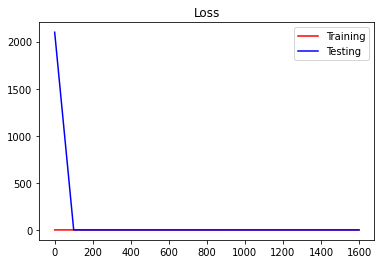

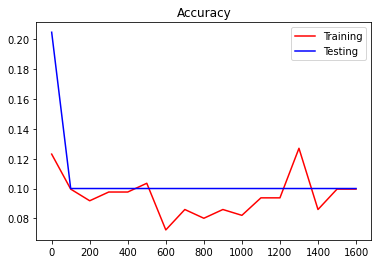

In [4]:
#### FEEL FREE TO MODIFY args VARIABLE HERE OR ABOVE ####
# args.gamma = float('inf')


# DON'T CHANGE
# prints out arguments and runs main
for attr in dir(args):
    if '__' not in attr and attr !='use_cuda':
        print('args.{} = {}'.format(attr, getattr(args, attr)))
print('\n\n')
model = main()

## Play with parameters.(3pt)
How many trainable parameters does the trained model have?

In [5]:
def param_count(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
print('Model has {} params'.format(param_count(model)))

Model has 454922 params


## Deep Linear Networks?!? (5pt)
Until this point, there are no non-linearities in the SimpleCNN! (Your TAs were just as surprised as you are at the results.) Your next task is to modify the code to add non-linear activation layers, and train your model in full scale. Make sure to add non-linearities at **every** applicable layer.

Compute the loss and accuracy curves on train and test sets after 5 epochs.

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.310275

Test set: Average loss: 966.2618, Accuracy: 1070/10000 (11%)

Train Epoch: 0 [100/60000 (85%)]	Loss: 0.910992

Test set: Average loss: 0.9456, Accuracy: 6676/10000 (67%)

Train Epoch: 1 [200/60000 (69%)]	Loss: 0.754256

Test set: Average loss: 0.8437, Accuracy: 7047/10000 (70%)

Train Epoch: 2 [300/60000 (54%)]	Loss: 0.744380

Test set: Average loss: 0.8041, Accuracy: 7078/10000 (71%)

Train Epoch: 3 [400/60000 (39%)]	Loss: 0.792697

Test set: Average loss: 0.8022, Accuracy: 7163/10000 (72%)

Train Epoch: 4 [500/60000 (24%)]	Loss: 0.810753

Test set: Average loss: 0.7489, Accuracy: 7373/10000 (74%)



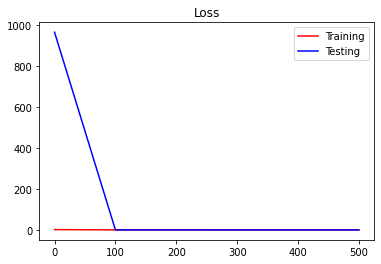

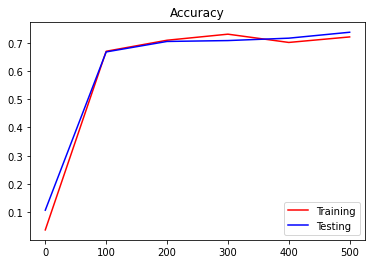

In [6]:
args.epochs = 5
# args.lr=1
model=main()

Where did you add your non-linearities? 
***
The nonlinear layers were added after the each linear layer in the original network as well as after every conv layer.
***

<br><br><br>
Provide some insights on why the results was fairly good even without activation layers. (**2** pts)

